In [1]:
import ee
import pandas as pd
ee.Initialize()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
collection = ee.ImageCollection('MODIS/006/MOD11A2')

In [3]:
# helper function to extract QA bits
def getQABits(image, start, end, newName):
    #Compute the bits we need to extract.
    pattern = 0;
    for i in range(start,end+1):
       pattern += math.pow(2, i);

    # Return a single band image of the extracted QA bits, giving the band
    # a new name.
    return image.select([0], [newName])\
                  .bitwiseAnd(int(pattern))\
                  .rightShift(start);
        
def qualityMask(image):
    quality = getQABits(image.select('QC_Day'),0,1,'qa')
    mask = quality.lte(1)
    return image.updateMask(mask)

qualityCollection = collection.map(qualityMask)

In [4]:
def smoothSeries(collection,window):
    def smoother(img):
        t = ee.Date(img.get('system:time_start'))
        val = collection.filterDate(t.advance(-window,'day'),t.advance(window,'day')).mean()
        return val.set('system:time_start',t.millis())
    return collection.map(smoother)

smoothCollection = smoothSeries(qualityCollection,15)

In [5]:
atl = ee.Geometry.Point([-84.3880,33.7490])

out = smoothCollection.select('LST_Day_1km').getRegion(atl,1000).getInfo()


df = pd.DataFrame(out[1:])
df.columns = out[0]
df.head(5)

,id,longitude,latitude,time,LST_Day_1km
0,2000_02_18,-84.392229,33.745214,950832000000,14911.500000
1,2000_02_26,-84.392229,33.745214,951523200000,14924.000000
2,2000_03_05,-84.392229,33.745214,952214400000,14893.333333
3,2000_03_13,-84.392229,33.745214,952905600000,14887.666667
4,2000_03_21,-84.392229,33.745214,953596800000,14936.666667


In [6]:
date = []
for i in range(df.shape[0]):
    date.append(pd.Timestamp(df.time[i]*1000000))
    
ts = pd.Series(np.array(df.LST_Day_1km)*0.02-273.15,index=date,name='lst')
ts.index.name = 'Date'

In [7]:
ts.head(5)

Date
2000-02-18    25.080000
2000-02-26    25.330000
2000-03-05    24.716667
2000-03-13    24.603333
2000-03-21    25.583333
Name: lst, dtype: float64

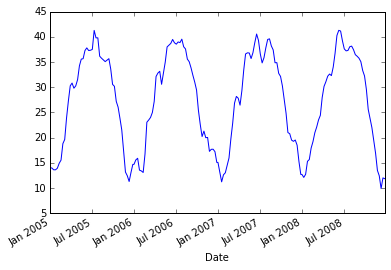

In [8]:
mask = (ts.index >='2005-01-01') & (ts.index<='2008-12-31')

ts.loc[mask].plot()